In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Nadam
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
import numpy as np
from keras.layers import BatchNormalization
from PIL import ImageFile

Using TensorFlow backend.


In [3]:
# ImageFile.LOAD_TRUNCATED_IMAGES = True

img_width, img_height = 600, 600
train_dir = 'data/train'
test_dir = 'data/test'

epochs = 15
batch_size = 8

In [4]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    validation_split= 0.2,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 1520 images belonging to 2 classes.
Found 380 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [5]:
import math

nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
# nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
# predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
# print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 1520
nb_validation_samples: 380

predict_size_train: 190
predict_size_validation: 48

 num_classes: 2


In [6]:
input_shape = Input([img_width, img_height, 3])
base_pretrained_model = InceptionV3(input_shape = [img_width, img_height, 3], include_top = False, weights = 'imagenet')

In [7]:
base_pretrained_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 600, 600, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 299, 299, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 299, 299, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 299, 299, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
# make the pretrained model trainable
base_pretrained_model.trainable = True

# extract features from pretrained model and feed to attention layers
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(input_shape)
bn_features = BatchNormalization()(pt_features)

In [9]:
# here we do an attention mechanism to enhance model accuracy
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)

# distribute to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = True
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(2, activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [input_shape], outputs = [out_layer])

retina_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 600, 600, 3)  0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 17, 17, 2048) 21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 17, 17, 2048) 8192        inception_v3[1][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 17, 17, 2048) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_95 

In [10]:
retina_model.compile(optimizer = Nadam(lr=0.00005), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=10, min_lr=0.000005, verbose=1)

In [12]:
weight = {0: 0.366, 1: 0.634}

retina_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    class_weight=weight,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size, verbose=2, callbacks=[reduce_lr])

Epoch 1/15
 - 117s - loss: 0.1353 - acc: 0.8632 - val_loss: 0.4183 - val_acc: 0.7979
Epoch 2/15
 - 102s - loss: 0.0219 - acc: 0.9783 - val_loss: 0.2825 - val_acc: 0.8883
Epoch 3/15
 - 102s - loss: 8.9673e-04 - acc: 1.0000 - val_loss: 0.3896 - val_acc: 0.8590
Epoch 4/15
 - 102s - loss: 0.0173 - acc: 0.9875 - val_loss: 0.5767 - val_acc: 0.8537
Epoch 5/15
 - 102s - loss: 0.0536 - acc: 0.9539 - val_loss: 0.7167 - val_acc: 0.8564
Epoch 6/15
 - 102s - loss: 0.0032 - acc: 1.0000 - val_loss: 0.8032 - val_acc: 0.8564
Epoch 7/15
 - 104s - loss: 8.6782e-04 - acc: 1.0000 - val_loss: 1.1494 - val_acc: 0.8564
Epoch 8/15
 - 103s - loss: 3.1694e-04 - acc: 1.0000 - val_loss: 1.3521 - val_acc: 0.8564
Epoch 9/15
 - 104s - loss: 1.7668e-04 - acc: 1.0000 - val_loss: 1.4889 - val_acc: 0.8564
Epoch 10/15
 - 104s - loss: 1.2513e-04 - acc: 1.0000 - val_loss: 1.4751 - val_acc: 0.8564
Epoch 11/15
 - 104s - loss: 1.4903e-04 - acc: 1.0000 - val_loss: 1.5966 - val_acc: 0.8564
Epoch 12/15
 - 104s - loss: 5.3768e-05 

In [13]:
score = retina_model.evaluate_generator(validation_generator, steps=50)

print ('Validation Loss: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Loss:  1.9978591750227817
Validation Accuracy:  0.8232323232323232


In [14]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = retina_model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

25/25 [==============================] - 4s 178ms/step
No of errors = 25/200


Confusion Matrix
[[  0  25]
 [  0 175]]


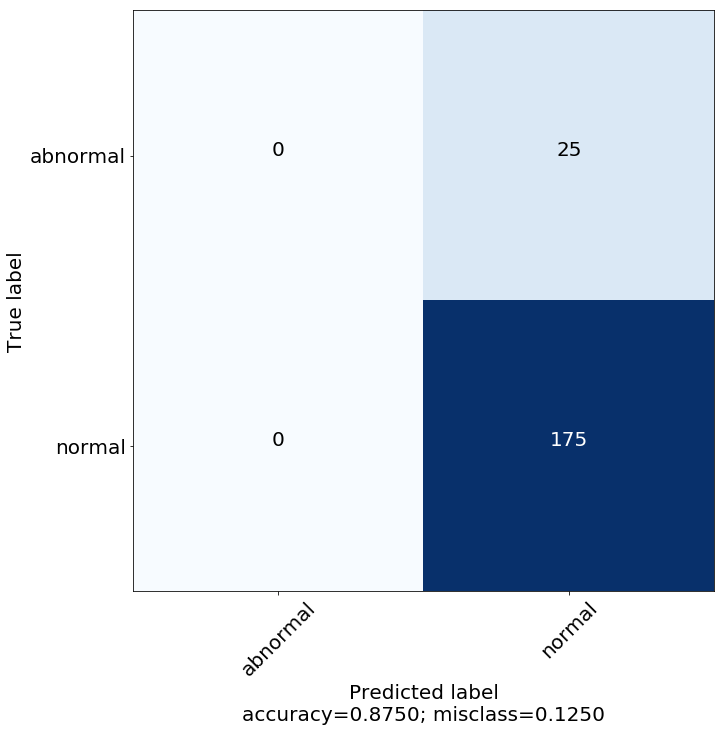

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[  0  25]
 [  0 175]]
             precision    recall  f1-score   support

   abnormal       0.00      0.00      0.00        25
     normal       0.88      1.00      0.93       175

avg / total       0.77      0.88      0.82       200



In [19]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Accuracy :  0.875
Sensitivity :  nan
Specificity :  0.875


In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc))
print('Precision: {:.4f}'.format(prec))
print('Recall:    {:.4f}'.format(recall))
print('F1:        {:.4f}'.format(f1))

Accuracy:  0.8750
Precision: 0.8750
Recall:    1.0000
F1:        0.9333
